## Predict activity directly
- Previous I used the difference in activity as the loss funciton
- What if we just fit a normal distribution to each protein/experiment, and try to predict the mean (optimum) and standard deviation (range) directly?

20240411: Try many other ML methods

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.hub.set_dir('/projects/robustmicrob/amondal2/torch/')
model_name = "esm2_t33_650M_UR50D"
# model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /projects/robustmicrob/amondal2/torch/facebookresearch_esm_main


### Build/get embeddings

In [17]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file, index_col=0)
    sequences.set_index("Enzyme", inplace=True)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [18]:
inputs_dir = Path("/projects/robustmicrob/amondal2/invizyne/inputs/")
# Load the esm2 embeddings for these proteins
# they were built using the src/build_embeddings.py script
embeddings, df_seq = read_embeddings(inputs_dir / "embedding_Kvid/embeddings_esm2_t33_650M_UR50D.npz",
                                     inputs_dir /"embedding_Kvid/embeddings_seqs.csv")
print(embeddings.shape)

len(embeddings) = 166 read from /projects/robustmicrob/amondal2/invizyne/inputs/embedding_Kvid/embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 166 read from /projects/robustmicrob/amondal2/invizyne/inputs/embedding_Kvid/embeddings_seqs.csv
(166, 1280)


In [19]:
df_seq

,Sequence
Enzyme,
M55A,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
M55C,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
M55G,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
M55S,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
M55T,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
...,...
S486M,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
S187P,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
P409G,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...


In [20]:
duplicated_sequences = df_seq[df_seq.duplicated(subset=['Sequence'], keep=False)]

# Get indices of duplicated sequences
duplicated_indices = duplicated_sequences.index.tolist()

print(duplicated_indices)

[]


In [21]:
embeddings.shape

(166, 1280)

In [12]:
#df_seq = df_seq.reset_index()
#df_seq.head(2)

In [28]:
# I fit a normal curve to the pH range data for each protein/reaction type with 2+ activity points
# e.g., 50% activity at pH 6, 100% activity at pH 7, 80% activity at pH 8
# This file has all of those curves, as well as a single pH optimum point (fit_mean) for proteins where it's available 
data_file = Path("/projects/robustmicrob/amondal2/invizyne/inputs/20240905_KivD_CFPS_dataset.xlsx")
data_fits = pd.read_excel(data_file, sheet_name=0) 
print(len(data_fits), data_fits.Enzyme.nunique())
data_fits.head(2)

166 166


,Enzyme,Sequence,control,75C activity,Unnamed: 4,Unnamed: 5
0,M55A,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.899318,0.063123,NaN,0.070190
1,M55C,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.685233,0.250574,NaN,0.365677


In [29]:
data_fits.columns

Index(['Enzyme', 'Sequence', 'control', '75C activity', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')

In [30]:
data_fits = data_fits.rename(columns={"Unnamed: 5": "retained","75C activity":"treated_at_75C"})
data_fits.head(2)

,Enzyme,Sequence,control,treated_at_75C,Unnamed: 4,retained
0,M55A,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.899318,0.063123,NaN,0.070190
1,M55C,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.685233,0.250574,NaN,0.365677


In [31]:
data_fits=data_fits.drop(columns=['Unnamed: 4'])
data_fits.head(2)

,Enzyme,Sequence,control,treated_at_75C,retained
0,M55A,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.899318,0.063123,0.070190
1,M55C,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.685233,0.250574,0.365677


In [32]:
data_fits.control.describe()

count    166.000000
mean       1.485388
std        0.931610
min        0.000000
25%        0.694635
50%        1.397203
75%        2.302533
max        3.375263
Name: control, dtype: float64

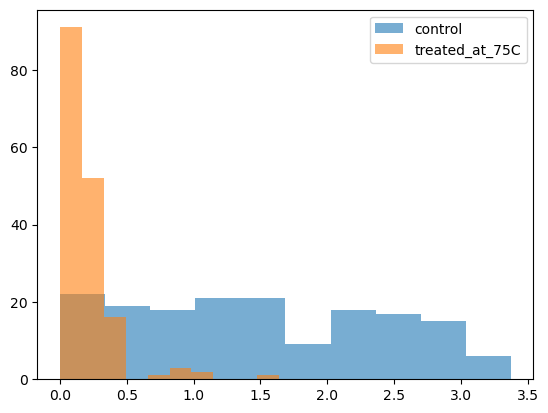

In [111]:
from matplotlib import pyplot as plt
plt.hist(data_fits['control'], bins=10, alpha=0.6, label='control')
plt.hist(data_fits['treated_at_75C'], bins=10, alpha=0.6, label='treated_at_75C')
plt.legend()
plt.savefig('kvid1.pdf')

In [34]:
data_fits = data_fits.drop(columns=['retained'])

In [35]:
data_fits = data_fits.replace("?", np.nan)

In [36]:
# oxidoreductases can often perform both oxidation and reduction
# so I manually annotated them by the type of reaction
#data_fits.reaction_type.value_counts()

In [37]:
print(f"# proteins with activity range data: {data_fits.dropna(subset='control').Enzyme.nunique()}")
#print(f"# proteins & reaction types with pH range data: {len(data_fits.dropna(subset='retained'))}")

# proteins with activity range data: 166


In [38]:
# Not all protein IDs matched a uniprot ID, so limit the proteins to those with an embedding
data_fits = data_fits[data_fits.Enzyme.isin(df_seq.index)]
print(data_fits.Enzyme.nunique(), len(data_fits))
# Make sure each row has a pH optimum
data_fits.dropna(subset=['control'], how="any", inplace=True)
print(data_fits.Enzyme.nunique(), len(data_fits))

166 166
166 166


In [39]:
data_fits['Enzyme'].value_counts()
#data_fits = data_fits.groupby(['Enzyme', 'Sequence'], as_index=False)['control'].mean()
data_fits = data_fits.groupby(['Enzyme', 'Sequence'], as_index=False).agg({'control': 'mean', 'treated_at_75C': 'mean'})

data_fits

,Enzyme,Sequence,control,treated_at_75C
0,A543D,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,1.687712,0.277195
1,A543E,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978471,0.171180
2,A543G,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978967,0.255148
3,A543N,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,3.025123,0.197173
4,A543S,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,3.375263,0.231579
...,...,...,...,...
161,W521F,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.918589,0.088687
162,W521I,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.975789,0.067757
163,W521L,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.914065,0.065764
164,W521V,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.521965,0.000000


In [40]:
data_fits = data_fits[data_fits.Enzyme.isin(df_seq.index)]
print(data_fits.Enzyme.nunique(), len(data_fits))
# Make sure each row has a pH optimum
data_fits.dropna(subset=['control'], how="any", inplace=True)
print(data_fits.Enzyme.nunique(), len(data_fits))

166 166
166 166


In [41]:
# df_seq_2=df_seq.reset_index()
# index = df_seq_2[df_seq_2['Enzyme'] == 'WT'].index.tolist()
# index2 = df_seq_2[df_seq_2['Enzyme'] == 'V13V'].index.tolist()
# index3 = df_seq_2[df_seq_2['Enzyme'] == 'I26I'].index.tolist()
# index,index2,index3

In [42]:
print(df_seq.columns)

Index(['Sequence'], dtype='object')


In [43]:
enz_to_seq = dict(zip(df_seq.index, df_seq.Sequence))
seq_to_enz = dict(zip(df_seq.Sequence, df_seq.index))


In [44]:
data_fits['Sequence'] = data_fits.Enzyme.apply(lambda x: enz_to_seq[x])

In [45]:
data_fits

,Enzyme,Sequence,control,treated_at_75C
0,A543D,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,1.687712,0.277195
1,A543E,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978471,0.171180
2,A543G,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978967,0.255148
3,A543N,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,3.025123,0.197173
4,A543S,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,3.375263,0.231579
...,...,...,...,...
161,W521F,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.918589,0.088687
162,W521I,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.975789,0.067757
163,W521L,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.914065,0.065764
164,W521V,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,0.521965,0.000000


In [46]:
# some uniprot IDs map to the same amino acid sequence
df_seq_uniq = data_fits['Sequence'].drop_duplicates()
print(len(df_seq_uniq), data_fits.Enzyme.nunique())

166 166


In [47]:
data_fits['Sequence'].value_counts()

Sequence
MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGNANELNASYMADGYARTKKAAAFLTTFGVGELSAVNGLAGSYAENLPVVEIVGSPTSKVQNEGKFVHHTLADGDFKHFMKMHEPVTAARTLLTAENATVEIDRVLSALLKERKPVYINLPVDVAAAKAEKPSLPLKKENSTSNTSDQEILNKIQESLKNAKKPIVITGHEIISFGLEKTVSQFISKTKLPITTLNFGKSSVDESLPSFLGIYNGKLSEPNLKEFVESADFILMLGVKLTDSSTGVFTHHLDENKMISLNIDEAKIFGESIQNFDFESLIKSLLDLSEIEYKGKYIDKKQEDFVPSNALLSQDRLWQAVEHLTQSNEVIVAEQGTSFFGVFPIRLKPGSTFIGQPLWGSIGYTFPATLGSQIADPERRHILFIGDGSLQMSVQELGLAIREGINPIIFIINNDGYTIEREIHGPNQSYNDIPMWNYSKLPESFGATEERVVSKIVTTENEFVSVMKEAQADPNRMYWIELILAKEDAPKVLKKMAKLLDEQNK    1
MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGNANELNASYMADGYARTKKAAAFLTTFGVGELSAVNGLAGSYAENLPVVEIVGSPTSKVQNEGKFVHHTLADGDFKHFMKMHEPVTAARTLLTAENATVEIDRVLSALLKERKPVYINLPVDVAAAKAEKPSLPLKKENSTSNTSDQEILNKIQESLKNAKKPIVITGHEIISFGLEKTVSQFISKTKLPITTLNFGKSSVDESLPSFLGIYNGKLSEPNLKEFVESADFILMLGVKLTDSSTGVFTHHLDENKMISLNIDEAKIFGESIQNFDFESLIKSLLDLSEIEYKGKYIDKKQEDFVPSNALLSQDRLWQAVEHLTQSNEVIVAEQGTSFFGVFPIRLKPGSTFIGQPLWGSIGYTFPATLGSQIADPERRHILFIGDGSLQMSVQE

In [49]:
## remove the duplication 
# specific_sequence = 'MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYMHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEPLTLMISNGMQTLGVALPWAIGASLVKPGEKVVSVSGDGGFLFSAMELETAVRLKAPIVHIVWNDSTYDMVAFQQLKKYNRTSGVDFGNIDIVKYAESFGATGLRVESPDQLADVLRQGMNAEGPVIIDVPVDYSDNINLASDKLPKEFGELMKTKAL'

# # Filter the DataFrame to get all rows where the sequence matches
# filtered_df = data_fits[data_fits['Sequence'] == specific_sequence]

# # Get the corresponding enzyme names and retained values as lists
# enzymes = filtered_df['Enzyme'].tolist()
# control_values = filtered_df['control'].tolist()
# at_60_values = filtered_df['treated_at_60C'].tolist()
# # Print the results
# print("Enzyme names:", enzymes)
# print("Control values:", control_values)
# print("at 60 values:", at_60_values)

In [50]:

# specific_sequence = 'MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYMHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEPLTLMISNGMQTLGVALPWAIGASLVKPGEKVVSVSGDGGFLFSAMELETAVRLKAPIVHIVWNDSTYDMVAFQQLKKYNRTSGVDFGNIDIVKYAESFGATGLRVESPDQLADVLRQGMNAEGPVIIDVPVDYSDNINLASDKLPKEFGELMKTKAL'
# filtered_df = data_fits[data_fits['Sequence'] == specific_sequence]

# # Step 2: Calculate the mean of the retained values
# mean_control = filtered_df['control'].mean()
# mean_at_60C = filtered_df['treated_at_60C'].mean()

# # Step 3: Create a new DataFrame row with the desired values
# new_row = pd.DataFrame({
#     'Enzyme': ['WT'],  # Enzyme name set to 'WT'
#     'Sequence': [specific_sequence],  # The same sequence
#     'control': [mean_control], # Mean of the retained values
#     'treated_at_60C': [mean_at_60C]  # Mean of the retained values
# })

# # Step 4: Remove the old duplicate rows from the original DataFrame
# data_fits = data_fits[data_fits['Sequence'] != specific_sequence]

# # Step 5: Append the new row with the mean retained value to the DataFrame
# data_fits = pd.concat([data_fits, new_row], ignore_index=True)

# # Check the result
# print(len(data_fits))
#print(data_fits.head())

In [52]:
# wt_rows = data_fits[data_fits['Enzyme'] == 'WT']

# # Display the filtered rows
# print(wt_rows)

In [53]:
df_seq_uniq.head(2)

0    MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
1    MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...
Name: Sequence, dtype: object

### Split into train/test

TODO Run more thorough evaluations
1. Random split holdout of all data
2. Random split holdout of proteins with pH range data to see if the pH optimum data improves the pH range predictions
3. 10-fold CV
4. Assign sequences to uniref50 clusters and holdout a subset of those clusters
    - More stringent evaluation to see how well the model can extrapolate to proteins with low sequence similarity to those in the training set

In [54]:
# just take a random split for now
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_seq_uniq.values, test_size=0.1)
train = set(train)
test = set(test)
print(len(train), len(test))

149 17


In [55]:
def train_test_split(seq):
    if isinstance(test, set):
        if seq in test:
            return "test"
    else:
        if seq in test.Sequence.values:
            return "test"
    return "train"

data_fits['split'] = data_fits.Sequence.apply(train_test_split)
df_split = data_fits[["Enzyme", "Sequence","control","treated_at_75C", "split"]].drop_duplicates()
df_split.head(2)

,Enzyme,Sequence,control,treated_at_75C,split
0,A543D,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,1.687712,0.277195,train
1,A543E,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978471,0.171180,train


### Choose the columns to use as features

In [56]:
from sklearn.preprocessing import OneHotEncoder

### Predict a normal distribution for each sequence
The loss will be the MAE of the points compared to the curve

In [57]:
df_split.split.value_counts()

split
train    149
test      17
Name: count, dtype: int64

In [58]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.Sequence, df_seq.reset_index().index))
# print(list(seq_idx.items())[:2])

In [59]:
df_train = data_fits[data_fits.split == "train"]
df_test = data_fits[data_fits.split == "test"]
df_train.head(2)

,Enzyme,Sequence,control,treated_at_75C,split
0,A543D,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,1.687712,0.277195,train
1,A543E,MYTVGDYLLDRLHELGIEHIFGVPGDYNLQFLDHIISRKDMKWVGN...,2.978471,0.171180,train


In [61]:
embeddings.shape

(166, 1280)

In [62]:
#embeddings[84,:].shape

In [63]:
#xx=embeddings[84,:]==embeddings[118,:]
#np.sum(xx)

In [65]:
def get_embeddings_and_features(df, embeddings, seq_idx):
    # some of the sequences are repeated, so get their embeddings by index
    X_split = np.asarray([embeddings[seq_idx[seq]] for seq in df.Sequence.values])
    #encoded_features = enc.transform(df[categ_cols]).toarray()
    #X_split = np.hstack([X_split, encoded_features])
    y_split = df[["control","treated_at_75C"]].values
    return X_split, y_split

# combine the sequence embeddings with the one-hot encoding of additional features (e.g., enzyme type, reaction type)
X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx)
X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx)
print(X_train.shape, f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(X_test.shape, f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(149, 1280) 0.90
(17, 1280) 0.10


In [66]:
X_test.shape

(17, 1280)

In [67]:
# max and min pH optimum
print(y_train[:,0].max(), y_train[:,0].min())
print(y_test[:,0].max(), y_test[:,0].min())

3.375263157894737 0.0
3.08155388471178 0.1103709273182958


In [68]:
print(y_train[:,1].max(), y_train[:,1].min())
print(y_test[:,1].max(), y_test[:,1].min())

1.63987969924812 0.0
1.103907268170426 0.0


In [69]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [70]:
class neural_network_fits(pl.LightningModule):
    def __init__(self, initial_layer_size=1280, lr=1e-3):
        """ Given an input esm2 sequence embedding, 
        predicts the retained activity.
        """
        super(neural_network_fits, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.LeakyReLU(),            
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
        )
        self.lr = lr
        # l1 loss reduction
        self.reduction = "mean"

    def forward(self, x):
        # predict the mean and std deviation
        logits = self.linear_relu_stack(x)
        # return logits
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]

        # take the sigmoid of the pH mean logits, then multiply by 13 to get in the range 0-13
        #y_pred = torch.sigmoid(logits[:,0])
        y_pred_control = logits[:, 0] 
        y_pred_at_60 = logits[:, 1]
        #y_pred_mean = torch.multiply(y_pred_mean, 13)
        # limit the standard deviation to between 0 and 4.25
        #y_pred_sigma = torch.sigmoid(logits[:,1])
        #y_pred_sigma = torch.multiply(y_pred_sigma, 4.25)
        return y_pred_control, y_pred_at_60
#         return dist, y_pred_mean, y_pred_sigma

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_true_control = y[:,0]
        
        y_true_at_60 = y[:,1]
        # logits = self(x)
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
        y_pred_control, y_pred_at_60= self(x)

        # use mse_loss or l1_loss (mae) on both the ph opt
        loss = nn.functional.l1_loss(y_pred_control, y_true_control, reduction=self.reduction)
        # and the ph standard deviation. Only use rows that are not nan
        loss += nn.functional.l1_loss(y_true_at_60, 
                                      y_pred_at_60,
                                      reduction=self.reduction)
        self.log('train_loss', loss)
        return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_ph, y_act = y[:,0], y[:,1]
        
#         y_pred = self(x)
#         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
#         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

#         loss = nn.functional.l1_loss(y_pred_act, y_act)
#         self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [71]:
def fit_model(X_train, y_train, X_valid, epochs=20, lr=1e-3):
    pl.seed_everything(42)
    model = neural_network_fits(initial_layer_size=X_train.shape[1], 
                                lr=lr,
                               )
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=epochs,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model, trainer

In [72]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [87]:
def eval_model(head_model, X_test, y_test, to_print=""):
    # logits = head_model(torch.Tensor(X_test)).detach().numpy()
    # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
    y_pred_control, y_pred_at_75 = head_model(torch.Tensor(X_test))
    y_pred_control= y_pred_control.detach().numpy()
    y_pred_at_75= y_pred_at_75.detach().numpy()
    y_true_control = y_test[:,0]
    y_true_at_75 = y_test[:,1]
    
    #df_err = pd.DataFrame({"activity retained": y_true, "NN_retained": y_pred})
    #y_pred_sigma = y_pred_sigma[~np.isnan(y_std)]
    #y_std = y_std[~np.isnan(y_std)]

    # now calculate the overall MAE
    # build a df instead of printing?
    # df_err = []
    # print("split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2")
    # #for y_true, y_pred, name in zip([y_opt, y_std], [y_pred_mean, y_pred_sigma], ["pH opt", "pH std"]):
    # rho, _ = spearmanr(y_pred, y_true)  # spearman
    # r2, _ = pearsonr(y_pred, y_true)  # spearman
    # mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
    # mae = np.mean(np.abs(y_pred - y_true))  # Mean Absolute Error
    # print(f"{to_print}{'Retained %'}, {mae:0.2f}, {mse:0.2f}, {rho:0.2f}, {r2:0.2f}")
        
    # return y_pred, df_err
    
    df_err = pd.DataFrame({"control": y_true_control, "at_75": y_true_at_75, "NN_control": y_pred_control, "NN_at_75": y_pred_at_75})
    #y_pred_sigma = y_pred_sigma[~np.isnan(y_std)]
    #y_std = y_std[~np.isnan(y_std)]

    # now calculate the overall MAE
    # build a df instead of printing?
    # df_err = []
    print("split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2")
    for y_true, y_pred, name in zip([y_true_control, y_true_at_75], [y_pred_control, y_pred_at_75], ["NN_control", "NN_at_75"]):
        rho, _ = spearmanr(y_pred, y_true)  # spearman
        r2, _ = pearsonr(y_pred, y_true)  # spearman
        mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
        mae = np.mean(np.abs(y_pred - y_true))  # Mean Absolute Error
        print(f"{to_print}{name}, {mae:0.2f}, {mse:0.2f}, {rho:0.2f}, {r2:0.2f}")
        
    return y_pred_control, y_pred_at_75, df_err

In [88]:
X_test.shape

(17, 1280)

In [89]:
# TODO run a full hyperparameter optimization
epochs = 2000
lr = 1e-4
# the model performs better with more of these features, 
# but they are not always available
#categ_col_sets = [
    # ['reaction_type'],
    # ['reaction_type', 'enzyme_type'],
    # ['reaction_type', 'enzyme_type', 'enzyme_type_sub'],
    #['reaction_type', 'enzyme_type', 'enzyme_type_sub', 'acceptor'],
#]
#for categ_cols in categ_col_sets:
  #  enc = get_one_hot_encoder(data_fits, categ_cols)
  #  X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx, enc, categ_cols)
   # X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx, enc, categ_cols)
# for batch_size in 
head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}")
eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}")

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
---------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.91it/s, v_num=58]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 135.69it/s, v_num=58]
split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 2000, 0.0001NN_control, 0.83, 0.97, 0.32, 0.43
test, 2000, 0.0001NN_at_75, 0.19, 0.09, 0.24, 0.40
split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
train, 2000, 0.0001NN_control, 0.58, 0.59, 0.68, 0.69
train, 2000, 0.0001NN_at_75, 0.10, 0.04, 0.63, 0.41


(array([ 1.25318635e+00,  1.33517396e+00,  2.07307506e+00,  1.89234006e+00,
         1.83634603e+00,  1.24908161e+00,  8.08903575e-01,  1.21070957e+00,
         7.38948584e-01,  5.29756486e-01,  2.86724138e+00,  1.02350426e+00,
         2.43860626e+00,  1.09996617e+00,  1.84700584e+00,  1.81602204e+00,
        -8.05417895e-02, -1.11907065e-01,  5.25275946e-01,  1.06824711e-02,
         2.00339460e+00,  1.39498305e+00,  1.77239072e+00,  2.83853918e-01,
         3.12246799e-01,  2.90672332e-01,  1.03120662e-01,  1.05363464e+00,
         8.40915442e-01,  1.10806799e+00,  1.36982131e+00,  1.19534874e+00,
         1.00566339e+00,  1.15338218e+00,  1.38299203e+00,  1.45178866e+00,
         1.74156475e+00,  1.63260245e+00,  1.48676896e+00,  2.09309196e+00,
         1.96176684e+00,  1.95534277e+00,  1.35388207e+00,  1.05998063e+00,
         5.65689802e-01,  7.26500750e-01,  1.24901450e+00,  1.28478265e+00,
         9.63546157e-01,  1.33578014e+00,  1.43830752e+00,  3.27132642e-01,
         7.3

In [90]:
y_pred_control, y_pred_at_75, df_err= eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr},")

split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 2000, 0.0001,NN_control, 0.83, 0.97, 0.32, 0.43
test, 2000, 0.0001,NN_at_75, 0.19, 0.09, 0.24, 0.40


In [91]:
df_err

,control,at_75,NN_control,NN_at_75
0,3.081554,0.116877,1.292321,0.111298
1,2.157211,0.849797,1.512380,0.256301
2,2.188303,0.165905,0.393602,0.066622
3,0.110371,0.000000,0.491318,0.072226
4,3.050479,0.279434,1.673122,0.094042
5,0.810115,0.169694,1.442806,0.108437
6,1.348406,0.116160,0.751992,0.141472
7,0.893045,0.255148,1.111866,0.171353
8,1.493456,0.171180,1.098228,0.184824
9,2.954664,0.116160,1.070187,0.179872


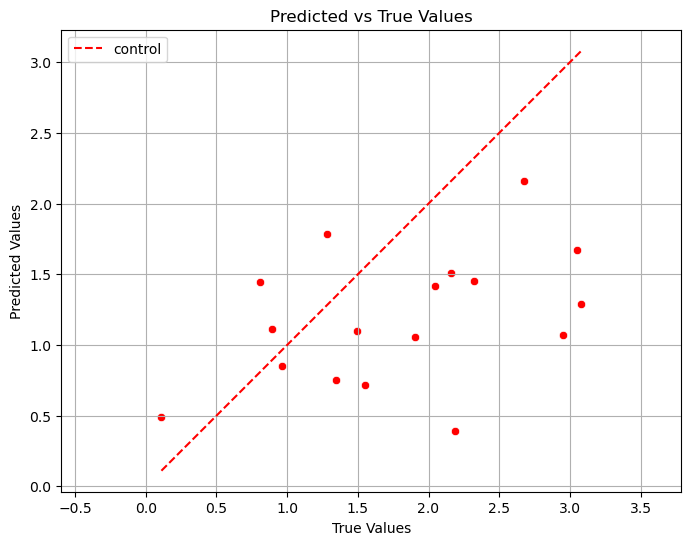

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns



# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test[:,0], y=y_pred_control, color='red')
#sns.scatterplot(x=y_test[:,1], y=y_pred_at_60, color='blue')

# Add a line for perfect prediction
plt.plot([min(y_test[:,0]), max(y_test[:,0])], [min(y_test[:,0]), max(y_test[:,0])], color='red', linestyle='--',label='control')

#plt.plot([min(y_test[:,1]), max(y_test[:,1])], [min(y_test[:,1]), max(y_test[:,1])], color='blue', linestyle='-',label='at 60')
# Set labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.axis('equal')  # Ensure equal scaling
plt.legend()
plt.grid()
plt.show()


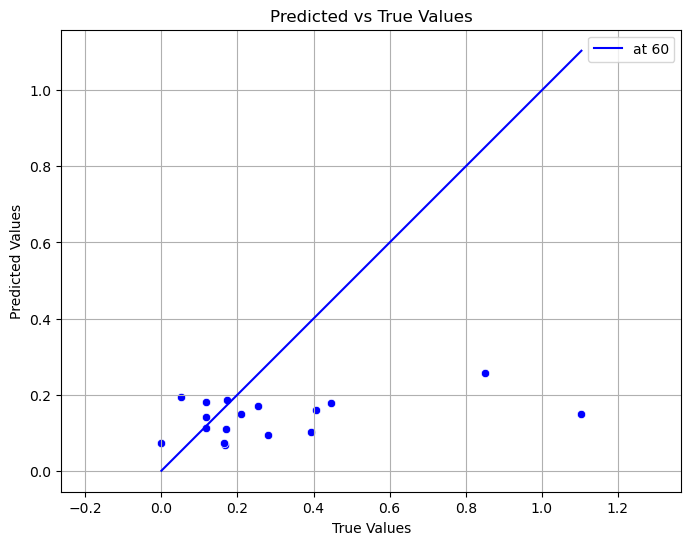

In [94]:
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test[:,0], y=y_pred_control, color='red')
sns.scatterplot(x=y_test[:,1], y=y_pred_at_75, color='blue')

# Add a line for perfect prediction
#plt.plot([min(y_test[:,0]), max(y_test[:,0])], [min(y_test[:,0]), max(y_test[:,0])], color='red', linestyle='--',label='control')

plt.plot([min(y_test[:,1]), max(y_test[:,1])], [min(y_test[:,1]), max(y_test[:,1])], color='blue', linestyle='-',label='at 60')
# Set labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.axis('equal')  # Ensure equal scaling
plt.legend()
plt.grid()
plt.show()

In [97]:
### Cross validation
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
     
# Function to perform K-Fold Cross-Validation
def k_fold_cross_validation(X, y, k=10, batch_size=32, epochs=100, lr=1e-3):
    kf = KFold(n_splits=k, shuffle=True)
    r2_scores = []  # To store R^2 scores for each fold
    r2_scores_75 = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create DataLoaders
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Initialize model
        model = neural_network_fits(initial_layer_size=X_train.shape[1], lr=lr)

        # Initialize a PyTorch Lightning Trainer
        trainer = pl.Trainer(max_epochs=epochs)

        # Train the model
        trainer.fit(model, train_loader)

        # Evaluate the model
        model.eval()
        y_pred_list = []
        y_true_list = []
        y_pred_list_2 = []
        y_true_list_2 = []

        with torch.no_grad():
            for val_batch in val_loader:
                x_val, y_val = val_batch
                y_pred_control, y_pred_at_75 = model(x_val)
                y_pred_list.append(y_pred_control.cpu().numpy())
                y_true_list.append(y_val[:, 0].cpu().numpy())  # Change this if you want the second output
                y_pred_list_2.append(y_pred_at_75.cpu().numpy())
                y_true_list_2.append(y_val[:, 1].cpu().numpy())

        y_pred = np.concatenate(y_pred_list)
        y_true = np.concatenate(y_true_list)

        y_pred_2 = np.concatenate(y_pred_list_2)
        y_true_2 = np.concatenate(y_true_list_2)
        

        # Calculate R² score
        r2 = r2_score(y_true, y_pred)
        r2_scores.append(r2)
        r2_75 = r2_score(y_true_2, y_pred_2)
        r2_scores_75.append(r2_75)
    print(r2_scores)
    print(r2_scores_75)
    print(f"Average R² Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# Example usage
# Assuming you have X and y as your feature and target arrays
k_fold_cross_validation(X_test, y_test, k=5, batch_size=32, epochs=2000, lr=1e-4)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot_h100/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
--------------------------------------------

Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.88it/s, v_num=62]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s, v_num=62]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot_h100/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
---------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pytorch_

Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.59it/s, v_num=63]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s, v_num=63]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot_h100/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
---------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pytorch_

Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.43it/s, v_num=64]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s, v_num=64]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot_h100/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
---------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pytorch_

Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.21it/s, v_num=66]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s, v_num=66]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot_h100/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K  | train
---------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pytorch_

Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.29it/s, v_num=67]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s, v_num=67]
[-0.542250394821167, 0.06000727415084839, -2.4518191814422607, -0.43430233001708984, 0.7269117832183838]
[-0.28317928314208984, -0.3988056182861328, -0.5476429462432861, -6.880416393280029, -1.8599531650543213]
Average R² Score: -0.5283 ± 1.0612


### Build neural net on sequence embeddings

TODO Try out different approaches to make predictions. Checkout the [UniKP](https://doi.org/10.1038/s41467-023-44113-1) paper for a good example
- Linear Regression, Ridge Regression
- Decision Tree, Random Forest, Gradient Boosting, AdaBoost
- Extra Trees (Performed the best)
- LGBM
- Feed forward neural network (implemented here)
- CNN, RNN

In [98]:
def run_simple_pred(model, X_train, y_train, X_test, y_test):
    # split into ph opt and ph range data
    train_control, train_75 = y_train[:,0], y_train[:,1]
    test_control, test_75 = y_test[:,0], y_test[:,1]
    # limit ph range to non-nan values
    #y_train = y_train[~np.isnan(y_train)]
    #y_test = y_test[~np.isnan(y_test)]

    model_act = model().fit(X_train, train_control)
    #train_phr_idx = np.argwhere(~np.isnan(y_train[:,1])).flatten()
    model_phr = model().fit(X_train, train_75)

    pred_control = model_act.predict(X_test)
    pred_75 = model_phr.predict(X_test)
    
    # combine the predictions back into a single vector(?)
    # no need to subset predictions to originally non-nan
    #y_pred = np.array(shape=y_test)
    # y_pred[np.argwhere(~np.isnan(y_test[:,1])),1] = pred_phr
    return pred_control, pred_75

In [99]:
# run simple predictors first
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

df_pred = pd.DataFrame()
for name, method in [("LR", LinearRegression), 
                     ("RR", Ridge),
                     ("KR", KernelRidge),
                     ("DTree",DecisionTreeRegressor),
                     ("RForest", RandomForestRegressor),
                     ("ExtraTrees", ExtraTreesRegressor),
                     ("GradientBoost", GradientBoostingRegressor),
                     ("AdaBoost", AdaBoostRegressor),
                    ]:
    print(name, method)
    pred_control, pred_75 = run_simple_pred(method, X_train, y_train, X_test, y_test)
    df_pred[f"{name}_control"] = pred_control
    df_pred[f"{name}_at75"] = pred_75
df_pred

LR <class 'sklearn.linear_model._base.LinearRegression'>
RR <class 'sklearn.linear_model._ridge.Ridge'>
KR <class 'sklearn.kernel_ridge.KernelRidge'>
DTree <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RForest <class 'sklearn.ensemble._forest.RandomForestRegressor'>
ExtraTrees <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
GradientBoost <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
AdaBoost <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>


/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,LR_control,LR_at75,RR_control,RR_at75,KR_control,KR_at75,DTree_control,DTree_at75,RForest_control,RForest_at75,ExtraTrees_control,ExtraTrees_at75,GradientBoost_control,GradientBoost_at75,AdaBoost_control,AdaBoost_at75
0,2.50,0.156250,1.455307,0.190031,1.455891,0.190015,3.101596,0.122692,2.392318,0.136311,2.590423,0.137215,2.577609,0.104336,2.557716,0.114979
1,3.25,0.328125,1.449245,0.192534,1.449372,0.192531,2.426253,0.303794,1.738268,0.280266,1.888155,0.303417,2.012489,0.261514,1.763707,0.300826
2,0.50,0.015625,1.442005,0.190487,1.444062,0.190429,0.309882,0.052895,1.103603,0.096182,0.657342,0.092231,0.695533,0.078367,0.585536,0.104171
3,0.75,-0.093750,1.440929,0.188914,1.440534,0.188926,0.395486,0.020348,1.137406,0.102950,0.992790,0.118570,1.000614,0.126566,0.982132,0.129046
4,1.00,0.203125,1.454073,0.189701,1.455380,0.189664,0.297211,0.000000,1.786015,0.239768,1.975716,0.184355,1.882899,0.359244,2.223606,0.167723
5,0.25,0.140625,1.446281,0.189839,1.447551,0.189803,0.322669,0.122692,1.575877,0.135930,1.639393,0.127285,1.626871,0.111251,1.524877,0.134499
6,1.50,0.187500,1.445035,0.189702,1.444648,0.189713,1.392875,0.020348,1.243521,0.204442,1.291257,0.194638,1.262144,0.166551,1.100102,0.245150
7,2.00,0.062500,1.447658,0.190001,1.447020,0.190019,1.257158,0.116877,1.511305,0.176549,1.412373,0.194457,1.699592,0.149805,1.206045,0.142476
8,1.75,0.078125,1.449474,0.189302,1.448027,0.189343,1.203965,0.276694,1.623415,0.221452,1.576678,0.187856,1.412425,0.233823,1.445842,0.200564
9,2.25,0.156250,1.443185,0.189096,1.442096,0.189127,2.632396,0.136346,2.319791,0.213539,2.479099,0.215098,2.407711,0.214508,2.523055,0.217941


In [100]:
df_err = df_err.rename(columns={"at_75": "at75"})
df_err = df_err.rename(columns={"NN_at_75": "NN_at75"})

df_pred_all = pd.concat([df_err, df_pred], axis=1)
df_pred_all

/home/amondal2/.conda-envs/prot_h100/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,control,at75,NN_control,NN_at75,LR_control,LR_at75,RR_control,RR_at75,KR_control,KR_at75,DTree_control,DTree_at75,RForest_control,RForest_at75,ExtraTrees_control,ExtraTrees_at75,GradientBoost_control,GradientBoost_at75,AdaBoost_control,AdaBoost_at75
0,3.081554,0.116877,1.292321,0.111298,2.50,0.156250,1.455307,0.190031,1.455891,0.190015,3.101596,0.122692,2.392318,0.136311,2.590423,0.137215,2.577609,0.104336,2.557716,0.114979
1,2.157211,0.849797,1.512380,0.256301,3.25,0.328125,1.449245,0.192534,1.449372,0.192531,2.426253,0.303794,1.738268,0.280266,1.888155,0.303417,2.012489,0.261514,1.763707,0.300826
2,2.188303,0.165905,0.393602,0.066622,0.50,0.015625,1.442005,0.190487,1.444062,0.190429,0.309882,0.052895,1.103603,0.096182,0.657342,0.092231,0.695533,0.078367,0.585536,0.104171
3,0.110371,0.000000,0.491318,0.072226,0.75,-0.093750,1.440929,0.188914,1.440534,0.188926,0.395486,0.020348,1.137406,0.102950,0.992790,0.118570,1.000614,0.126566,0.982132,0.129046
4,3.050479,0.279434,1.673122,0.094042,1.00,0.203125,1.454073,0.189701,1.455380,0.189664,0.297211,0.000000,1.786015,0.239768,1.975716,0.184355,1.882899,0.359244,2.223606,0.167723
5,0.810115,0.169694,1.442806,0.108437,0.25,0.140625,1.446281,0.189839,1.447551,0.189803,0.322669,0.122692,1.575877,0.135930,1.639393,0.127285,1.626871,0.111251,1.524877,0.134499
6,1.348406,0.116160,0.751992,0.141472,1.50,0.187500,1.445035,0.189702,1.444648,0.189713,1.392875,0.020348,1.243521,0.204442,1.291257,0.194638,1.262144,0.166551,1.100102,0.245150
7,0.893045,0.255148,1.111866,0.171353,2.00,0.062500,1.447658,0.190001,1.447020,0.190019,1.257158,0.116877,1.511305,0.176549,1.412373,0.194457,1.699592,0.149805,1.206045,0.142476
8,1.493456,0.171180,1.098228,0.184824,1.75,0.078125,1.449474,0.189302,1.448027,0.189343,1.203965,0.276694,1.623415,0.221452,1.576678,0.187856,1.412425,0.233823,1.445842,0.200564
9,2.954664,0.116160,1.070187,0.179872,2.25,0.156250,1.443185,0.189096,1.442096,0.189127,2.632396,0.136346,2.319791,0.213539,2.479099,0.215098,2.407711,0.214508,2.523055,0.217941


In [103]:
method_list = ["NN", "LR", "RR", "KR", 
               "DTree","RForest", "ExtraTrees", 
               "GradientBoost", "AdaBoost"
              ]
# df_err_all = pd.DataFrame()
# results = []
# for name in method_list:
#     for col, pred_col in zip(["pH opt",], [f"{name}_retained", f"{name}_phr"]):
#     y_pred = df_pred_all[name+"_retained"]
#     y_true = df_pred_all["activity retained"]
#     r2, _ = pearsonr(y_pred, y_true)  # pearsonr
#     rho, _ = spearmanr(y_pred, y_true)  # spearman
#     mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
#     mae = np.mean(np.abs(y_pred - y_true))# Mean Absolute Error
#     results += [[name,  mae, mse, rho, r2]]
# results

results = []
for name in method_list:
    for col, pred_col in zip(["control", "at75"], [f"{name}_control", f"{name}_at75"]):
        y_pred = df_pred_all.dropna(subset=col)[pred_col]
        y_true = df_pred_all.dropna(subset=col)[col]
        r2, _ = pearsonr(y_pred, y_true)  # pearsonr
        rho, _ = spearmanr(y_pred, y_true)  # spearman
        mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
        mae = np.mean(np.abs(y_pred - y_true))  # Mean Absolute Error
        results += [[pred_col.split("_")[0], col, mae, mse, rho, r2]]
results

[['NN',
  'control',
  np.float64(0.8253298809368069),
  0.9704655930114091,
  np.float64(0.32352941176470595),
  np.float64(0.4250028152030457)],
 ['NN',
  'at75',
  np.float64(0.19183193249011243),
  0.09306343406789287,
  np.float64(0.23543842561379705),
  np.float64(0.3978687150861751)],
 ['LR',
  'control',
  np.float64(0.8683889134601209),
  1.0684087468930326,
  np.float64(0.34317576814678696),
  np.float64(0.33196839754775936)],
 ['LR',
  'at75',
  np.float64(0.13848332227627894),
  0.034445413305736645,
  np.float64(0.6898039603349708),
  np.float64(0.8353975879784464)],
 ['RR',
  'control',
  np.float64(0.750064728867653),
  0.8299652675709391,
  np.float64(0.47794117647058826),
  np.float64(0.5190113752551851)],
 ['RR',
  'at75',
  np.float64(0.17977330780319634),
  0.08854369203669753,
  np.float64(0.15573270860912616),
  np.float64(0.570125586467787)],
 ['KR',
  'control',
  np.float64(0.7500067918271587),
  0.8296682627052179,
  np.float64(0.482843137254902),
  np.float64

In [104]:
df_stats = pd.DataFrame(results, columns=["method", "type","MAE", "MSE", "rho", "R2"])
df_stats

,method,type,MAE,MSE,rho,R2
0,NN,control,0.825330,0.970466,0.323529,0.425003
1,NN,at75,0.191832,0.093063,0.235438,0.397869
2,LR,control,0.868389,1.068409,0.343176,0.331968
3,LR,at75,0.138483,0.034445,0.689804,0.835398
4,RR,control,0.750065,0.829965,0.477941,0.519011
5,RR,at75,0.179773,0.088544,0.155733,0.570126
6,KR,control,0.750007,0.829668,0.482843,0.546076
7,KR,at75,0.179776,0.088547,0.163090,0.573645
8,DTree,control,0.583500,0.824323,0.396076,0.488373
9,DTree,at75,0.166801,0.074885,0.554669,0.564317


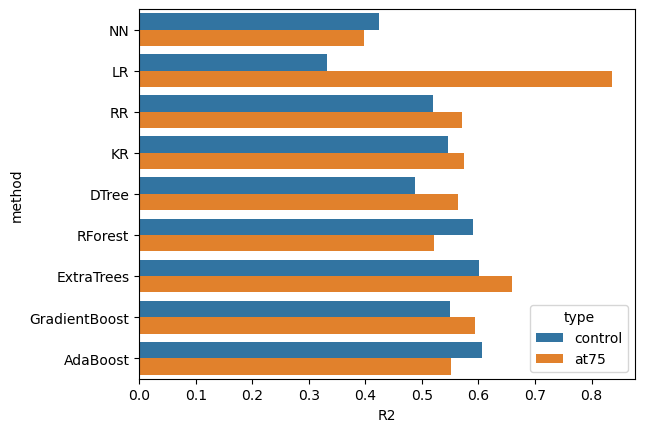

In [112]:
sns.barplot(data=df_stats, y="method", x="R2",hue="type")
plt.savefig('kvid2.png')

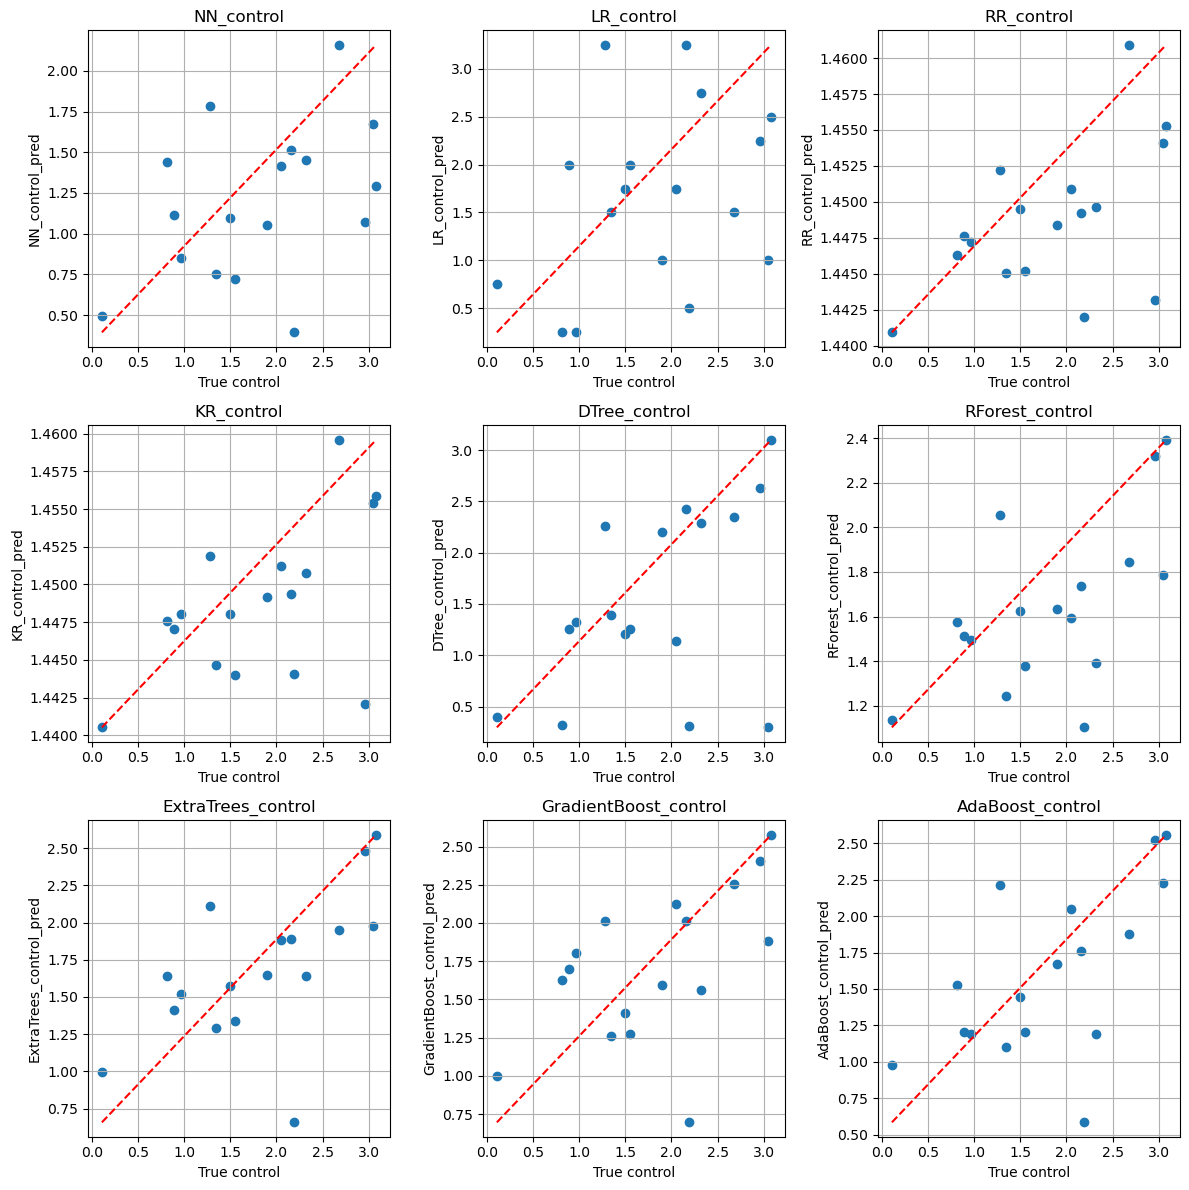

In [113]:
#num_cols = len(df_pred_all.columns) -   # Exclude the first column for x-axis
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
# Plot each column against the first column
for i, column in enumerate(df_pred_all.columns[2::2]):  # Skip the first column
    axes[i].scatter(df_pred_all['control'], df_pred_all[column], marker='o', linestyle='-')
    axes[i].plot([min(df_pred_all['control']), max(df_pred_all['control'])], [min(df_pred_all[column]), max(df_pred_all[column])], color='red', linestyle='--')
    axes[i].set_title(column)
    axes[i].set_xlabel('True control')
    axes[i].set_ylabel(column+'_pred')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig('kivd3.pdf')
plt.show()


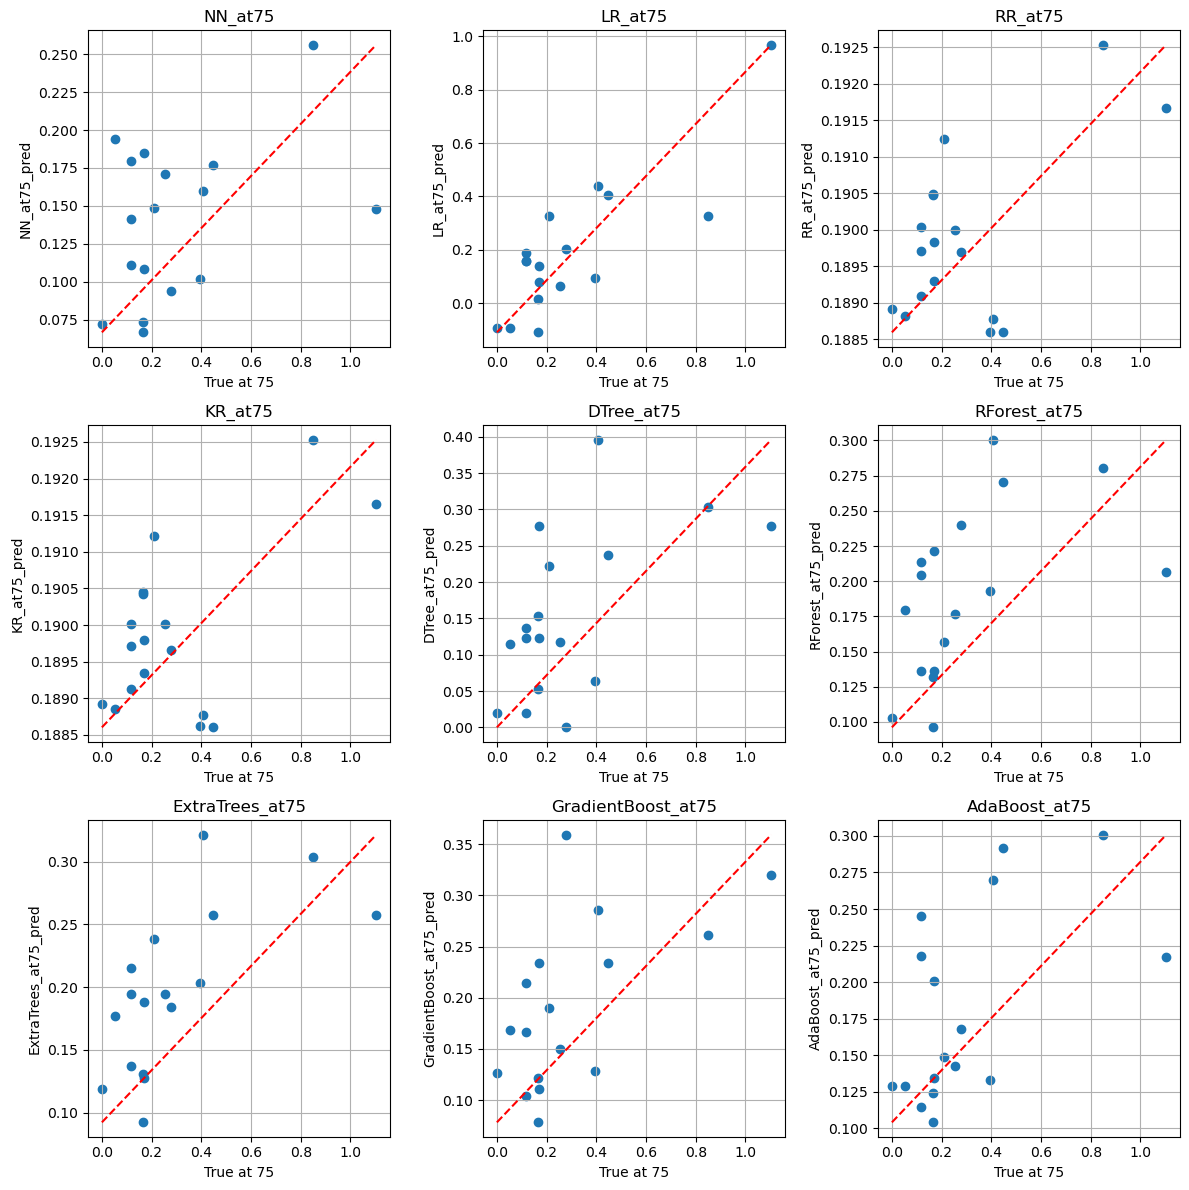

In [109]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
# Plot each column against the first column
for i, column in enumerate(df_pred_all.columns[3::2]):  # Skip the first column
    axes[i].scatter(df_pred_all['at75'], df_pred_all[column], marker='o', linestyle='-')
    axes[i].plot([min(df_pred_all['at75']), max(df_pred_all['at75'])], [min(df_pred_all[column]), max(df_pred_all[column])], color='red', linestyle='--')
    axes[i].set_title(column)
    axes[i].set_xlabel('True at 75')
    axes[i].set_ylabel(column+'_pred')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig('kvid_3.pdf')
plt.show()


##### Light attention

In [47]:
def replace_noncanonical(seq, replace_char='X'):
    '''Replace all non-canonical amino acids with a specific character'''

    for char in ['B', 'J', 'O', 'U', 'Z']:
        seq = seq.replace(char, replace_char)
    return seq

In [52]:
# use the esm1v model to match ephod (for now)
torch.hub.set_dir('/projects/robustmicrob/amondal2/torch/')
# model_name = "esm2_t33_650M_UR50D"
model_name = "esm1v_t33_650M_UR90S_1"
esm1v_model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
esm1v_model.eval()  # disables dropout for deterministic results
esm1v_model = esm1v_model.to(device)
batch_converter = alphabet.get_batch_converter()

# def load_ESM1v_model(self):
#     '''Return pretrained ESM1v model weights and batch converter'''

#     model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
#     model = model.to(self.device)
#     batch_converter = alphabet.get_batch_converter()

#     return model, batch_converter


def get_ESM1v_embeddings(accs, seqs):
    '''Return per-residue embeddings (padded) for protein sequences from ESM1v model'''

    seqs = [replace_noncanonical(seq, 'X') for seq in seqs]
    data = [(accs[i], seqs[i]) for i in range(len(accs))]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device=device, non_blocking=True)
    emb = esm1v_model(batch_tokens, repr_layers=[33], return_contacts=False)
    emb = emb["representations"][33]
    emb = emb.transpose(2,1) # From (batch, seqlen, features) to (batch, features, seqlen)
    emb = emb.to(device)

    return emb

Using cache found in /projects/robustmicrob/amondal2/torch/facebookresearch_esm_main


In [53]:
data_fits.head()

,Enzyme,Sequence,control,treated_at_60C,split
0,A375I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.571659,0.208737,train
1,A375L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.645425,0.288568,train
2,A375M,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.492444,0.251209,train
3,A375T,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.818716,0.447756,train
4,A375V,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.879385,0.378236,train


In [54]:
accs, seqs = data_fits.head()["Enzyme"].values, data_fits.head()["Sequence"].values

In [55]:
test = get_ESM1v_embeddings(accs, seqs)

In [56]:
test.shape

torch.Size([5, 1280, 573])

In [57]:
def torchActivation(activation='elu'):
    '''Return an activation function from torch.nn'''

    if activation == 'relu':
        return nn.ReLU()

    elif activation == 'leaky_relu':
        return nn.LeakyReLU()

    elif activation == 'elu':
        return nn.ELU()

    elif activation == 'selu':
        return nn.SELU()

    elif activation == 'gelu':
        return nn.GELU()


class ResidualDense(nn.Module):
    '''A single dense layer with residual connection'''

    def __init__(self, dim=2560, dropout=0.1, activation='elu', random_seed=0):

        super(ResidualDense, self).__init__()
        _ = torch.manual_seed(random_seed)
        self.dense = nn.Linear(dim, dim)
        self.batchnorm = nn.BatchNorm1d(dim)
        self.activation = torchActivation(activation)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):

        x0 = x
        x = self.dense(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = x0 + x

        return x


class LightAttention(nn.Module):
    '''Convolution model with attention to learn pooled representations from embeddings'''

    def __init__(self, dim=1280, kernel_size=7, random_seed=0):

        super(LightAttention, self).__init__()
        _ = torch.manual_seed(random_seed)
        samepad = kernel_size // 2
        self.values_conv = nn.Conv1d(dim, dim, kernel_size=kernel_size, padding=samepad)
        self.weights_conv = nn.Conv1d(dim, dim, kernel_size=kernel_size, padding=samepad)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x, mask=None):
        if mask is None:
            mask = torch.ones(x.shape[0], x.shape[2], dtype=torch.int32)  # Don't mask out
        values = self.values_conv(x)
        values = values.masked_fill(mask[:,None,:]==0, -1e6)
        weights = self.weights_conv(x)
        weights = weights.masked_fill(mask[:,None,:]==0, -1e6)
        weights = self.softmax(weights)
        x_sum = torch.sum(values * weights, dim=-1) # Attention-weighted pooling
        x_max, _ = torch.max(values, dim=-1) # Max pooling
        x = torch.cat([x_sum, x_max], dim=1)

        return x, weights
    

class ResidualLightAttention(nn.Module):
    '''Model consisting of light attention followed by residual dense layers'''

    def __init__(self, dim=1280, kernel_size=9, dropout=0.5,
                 activation='relu', res_blocks=4, random_seed=0):

        super(ResidualLightAttention, self).__init__()
        torch.manual_seed(random_seed)
        self.light_attention = LightAttention(dim, kernel_size, random_seed)
        self.batchnorm = nn.BatchNorm1d(2 * dim)
        self.dropout = nn.Dropout(dropout)
        self.residual_dense = nn.ModuleList()
        for i in range(res_blocks):
            self.residual_dense.append(
                ResidualDense(2 * dim, dropout, activation, random_seed)
                )
        self.output = nn.Linear(2 * dim, 2)


    def forward(self, x, mask=None):

        x, weights = self.light_attention(x, mask)
        x = self.batchnorm(x)
        x = self.dropout(x)
        for layer in self.residual_dense:
            x = layer(x)
        y = self.output(x).flatten()

        return [y, x, weights]

In [58]:
# class RLA_fits(pl.LightningModule, ResidualLightAttention):
#     def __init__(self, initial_layer_size=1280, lr=1e-3):
#         """ Given an input esm2 sequence embedding, 
#         predicts the mean and sigma (standard deviation) parameters e.g., for pH activity curves.
#         """
#         super(neural_network_fits, self).__init__()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(initial_layer_size, 512),
#             nn.LeakyReLU(),            
#             nn.Linear(512, 512),
#             nn.LeakyReLU(),
#             nn.Linear(512, 2),
#         )
#         self.lr = lr
#         # l1 loss reduction
#         self.reduction = "mean"

#     def forward(self, x):
#         # predict the mean and std deviation
#         logits = self.linear_relu_stack(x)
#         # return logits
#         # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]

#         # take the sigmoid of the pH mean logits, then multiply by 13 to get in the range 0-13
#         y_pred_mean = logits[:,0]
#         #y_pred_mean = torch.multiply(y_pred_mean, 13)
#         # limit the standard deviation to between 0 and 4.25
#         y_pred_sigma = logits[:,1]
#         #y_pred_sigma = torch.multiply(y_pred_sigma, 4.25)
#         return y_pred_mean, y_pred_sigma
# #         return dist, y_pred_mean, y_pred_sigma

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_opt, y_std = y[:,0], y[:,1]
        
#         # logits = self(x)
#         # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
#         y_pred_mean, y_pred_sigma = self(x)

#         # use mse_loss or l1_loss (mae) on both the ph opt
#         loss = nn.functional.l1_loss(y_pred_mean, y_opt, reduction=self.reduction)
#         # and the ph standard deviation. Only use rows that are not nan
#         loss += nn.functional.l1_loss(y_pred_sigma[~torch.isnan(y_std)], 
#                                       y_std[~torch.isnan(y_std)],
#                                       reduction=self.reduction)
#         self.log('train_loss', loss)
#         return loss
    
# #     def validation_step(self, batch, batch_idx):
# #         x, y = batch
# #         y_ph, y_act = y[:,0], y[:,1]
        
# #         y_pred = self(x)
# #         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
# #         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

# #         loss = nn.functional.l1_loss(y_pred_act, y_act)
# #         self.log("val_loss", loss)
        
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
#         return optimizer

In [59]:
# class RLA_fits(pl.LightningModule, ResidualLightAttention):
#     def __init__(self, dim, *args, **kwargs):  # Add the 'dim' argument
#         super().__init__(*args, **kwargs)
#         self.dim = dim
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_control, y_60 = y[:,0], y[:,1]
        
#         # logits = self(x)
#         # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
#         # y_pred_mean, y_pred_sigma = self(x)
#         logits, prev_logits, weights = self(x)
#         y_pred_control, y_pred_60 = logits[:,0], logits[:,1]

#         # use mse_loss or l1_loss (mae) on both the ph opt
#         loss = nn.functional.l1_loss(y_pred_control, y_control, reduction=self.reduction)
#         # and the ph standard deviation. Only use rows that are not nan
#         loss += nn.functional.l1_loss(y_pred_60[~torch.isnan(y_60)], 
#                                       y_60[~torch.isnan(y_60)],
#                                       reduction=self.reduction)
#         self.log('train_loss', loss)
#         return loss
    
# #     def validation_step(self, batch, batch_idx):
# #         x, y = batch
# #         y_ph, y_act = y[:,0], y[:,1]
        
# #         y_pred = self(x)
# #         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
# #         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

# #         loss = nn.functional.l1_loss(y_pred_act, y_act)
# #         self.log("val_loss", loss)
        
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
#        return optimizer

In [60]:
class RLA_fits(pl.LightningModule,ResidualLightAttention):
    def __init__(self, initial_layer_size=1280, lr=1e-3):
        """ Given an input esm2 sequence embedding, 
        predicts the mean and sigma (standard deviation) parameters e.g., for pH activity curves.
        """
        super().__init__()  # Correct the super() call
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.LeakyReLU(),            
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
        )
        self.lr = lr
        # l1 loss reduction
        self.reduction = "mean"

    def forward(self, x):
        # predict the mean and std deviation
        logits = self.linear_relu_stack(x)
        
        # Directly use raw logits (without sigmoid or range constraints)
        y_pred_mean = logits[:, 0]
        y_pred_sigma = logits[:, 1]
        
        return y_pred_mean, y_pred_sigma

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_opt, y_std = y[:,0], y[:,1]
        
        y_pred_mean, y_pred_sigma = self(x)

        # use mse_loss or l1_loss (mae) on both the ph opt
        loss = nn.functional.l1_loss(y_pred_mean, y_opt, reduction=self.reduction)
        # and the ph standard deviation. Only use rows that are not nan
        loss += nn.functional.l1_loss(y_pred_sigma[~torch.isnan(y_std)], 
                                      y_std[~torch.isnan(y_std)],
                                      reduction=self.reduction)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [61]:
test = RLA_fits()


In [62]:
test

RLA_fits(
  (light_attention): LightAttention(
    (values_conv): Conv1d(1280, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
    (weights_conv): Conv1d(1280, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
    (softmax): Softmax(dim=-1)
  )
  (batchnorm): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (residual_dense): ModuleList(
    (0-3): 4 x ResidualDense(
      (dense): Linear(in_features=2560, out_features=2560, bias=True)
      (batchnorm): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=2560, out_features=2, bias=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_sl

In [63]:
def fit_model(X_train, y_train,  epochs=20, lr=1e-3):
    pl.seed_everything(42)
    #model = RLA_fits(dim=X_train.shape[1])
    model = RLA_fits()
                                # lr=lr,
                               
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=epochs,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model, trainer

In [64]:
model, trainer = fit_model(X_train, y_train, epochs=2000, lr=1e-4)


Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/amondal2/.conda-envs/prot-eng/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot-eng/lib/python3.10/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amondal2/.conda-envs/prot-eng/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your inten

Epoch 1999: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 203.14it/s, v_num=54]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 187.39it/s, v_num=54]


In [65]:
X_test

array([[-0.01683 ,  0.01521 , -0.01322 , ..., -0.1283  , -0.01013 ,
         0.07715 ],
       [-0.01778 ,  0.01391 , -0.013535, ..., -0.1274  , -0.01126 ,
         0.07635 ],
       [-0.01747 ,  0.01361 , -0.01351 , ..., -0.1278  , -0.01122 ,
         0.07733 ],
       ...,
       [-0.01689 ,  0.01561 , -0.014465, ..., -0.1252  , -0.012474,
         0.0742  ],
       [-0.01866 ,  0.01389 , -0.01062 , ..., -0.1261  , -0.01306 ,
         0.07587 ],
       [-0.01735 ,  0.01414 , -0.01112 , ..., -0.1265  , -0.01165 ,
         0.07404 ]], dtype=float16)

In [66]:
X_test_tensor = torch.from_numpy(X_test).float()  # Convert to PyTorch tensor

# Move the tensor to the appropriate device (CPU or GPU)
if torch.cuda.is_available():
    X_test_tensor = X_test_tensor.to('cuda')

In [67]:
X_test_tensor

tensor([[-0.0168,  0.0152, -0.0132,  ..., -0.1283, -0.0101,  0.0771],
        [-0.0178,  0.0139, -0.0135,  ..., -0.1274, -0.0113,  0.0764],
        [-0.0175,  0.0136, -0.0135,  ..., -0.1278, -0.0112,  0.0773],
        ...,
        [-0.0169,  0.0156, -0.0145,  ..., -0.1252, -0.0125,  0.0742],
        [-0.0187,  0.0139, -0.0106,  ..., -0.1261, -0.0131,  0.0759],
        [-0.0173,  0.0141, -0.0111,  ..., -0.1265, -0.0117,  0.0740]],
       device='cuda:0')

In [68]:
if torch.cuda.is_available():
    model = model.to('cuda')  

In [69]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred_control, y_pred_60 = model(X_test_tensor)  #

In [70]:
y_pred_control=y_pred_control.cpu().numpy()

In [71]:
y_pred_60=y_pred_60.cpu().numpy()

In [72]:
from sklearn.metrics import r2_score

In [73]:
mae = np.mean(np.abs(y_pred_control - y_test[:,0]))
mse = np.mean((y_pred_control - y_test[:,0]) ** 2)
r2 = r2_score(y_test[:,0], y_pred_control)
print('for control', mae,mse,r2)

for control 0.31345778504094035 0.14843881104572448 0.2844118732523577


In [74]:
mae = np.mean(np.abs(y_pred_control - y_test[:,1]))
mse = np.mean((y_pred_control - y_test[:,1]) ** 2)
r2 = r2_score(y_test[:,1], y_pred_60)
print('for 60', mae,mse,r2)

for 60 0.5631524635387329 0.35254585909860287 -0.314650036087911


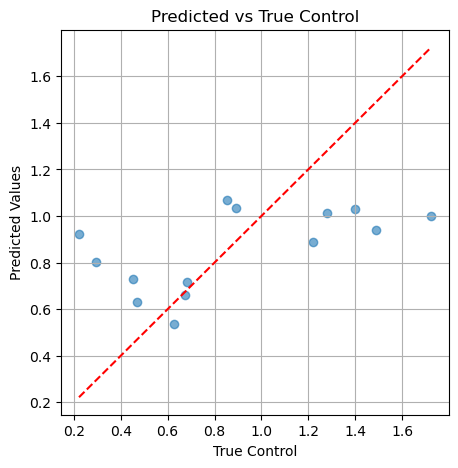

In [77]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test[:,0], y_pred_control, alpha=0.6)
plt.plot([y_test[:,0].min(), y_test[:,0].max()], [y_test[:,0].min(), y_test[:,0].max()], 'r--')  # Identity line
plt.xlabel("True Control")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Control")
plt.grid()
plt.show()

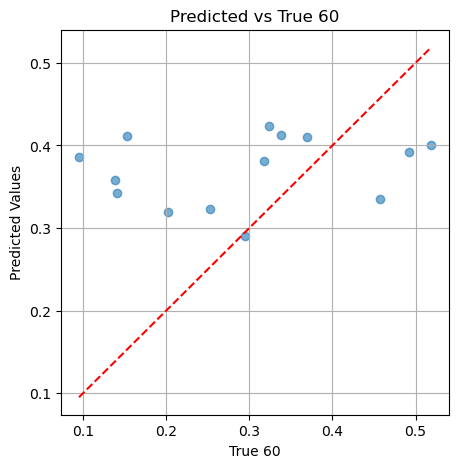

In [76]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test[:,1], y_pred_60, alpha=0.6)
plt.plot([y_test[:,1].min(), y_test[:,1].max()], [y_test[:,1].min(), y_test[:,1].max()], 'r--')  # Identity line
plt.xlabel("True 60")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True 60")
plt.grid()
plt.show()